In [12]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import collections

In [17]:
df  = pd.read_csv('/Users/Ada/Desktop/NYPD_Complaint_Data_Historic.csv',  low_memory=False) 
listing = pd.read_csv('/Users/Ada/Desktop/listings.csv',  low_memory=False)
crime_data = pd.read_csv('/Users/Ada/Desktop/Crime_Column_Description.csv', low_memory=False)


In [20]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [10]:
listing.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2515,Stay at Chez Chic budget room #1,2758,Steph,Manhattan,Harlem,40.799205,-73.953676,Private room,59,2,175,2018-11-18,1.42,3,298
1,21456,Light-filled classic Central Park,42032,Dana,Manhattan,Upper West Side,40.797642,-73.961775,Entire home/apt,140,5,76,2018-10-16,0.72,1,248
2,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647486,-73.972370,Private room,149,1,9,2018-10-19,0.25,8,365
3,21644,"Upper Manhattan, New York",82685,Elliott,Manhattan,Harlem,40.828028,-73.947308,Private room,89,1,1,2018-10-09,0.51,1,365
4,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753621,-73.983774,Entire home/apt,225,1,41,2018-12-02,0.37,2,350


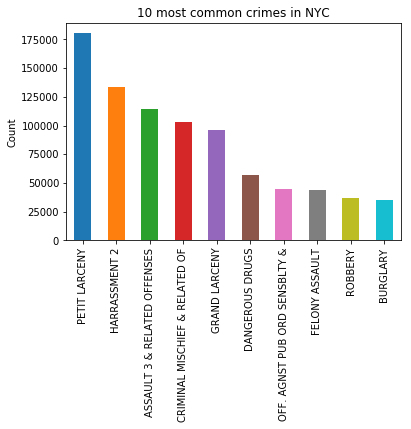

In [26]:
df['OFNS_DESC'].value_counts()[:10].plot.bar()
plt.ylabel('Count')
plt.title('10 most common crimes in NYC')
plt.show()

 Petit Larceny (AKA Petty Theft) is the most frequent offense.

Text(0.5, 0, 'Level of Offense')

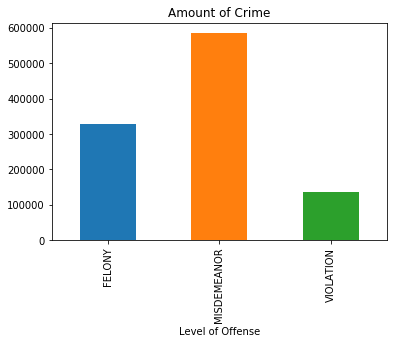

In [64]:
level_count = df.groupby(['LAW_CAT_CD']).count()['CMPLNT_NUM']
level_count.plot.bar(stacked=False)
plt.title('Amount of Crime')
plt.xlabel('Level of Offense')


LAW_CAT_CD - Level of offense: felony, misdemeanor, violation <br>
Misdemeanor is the one happens most.

Text(0.5, 0, 'Level of Offense')

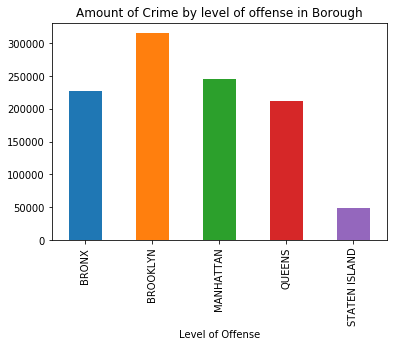

In [65]:
level_count = df.groupby(['BORO_NM']).count()['CMPLNT_NUM']
level_count.plot.bar(stacked=False)
plt.title('Amount of Crime by Borough')
plt.xlabel('Borough')

Brooklyn has most crime reports. 

Text(0.5, 0, 'Borough,Level of Offense')

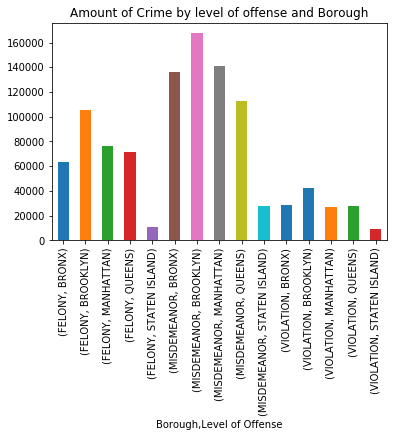

In [66]:
level_count = df.groupby(['LAW_CAT_CD','BORO_NM']).count()['CMPLNT_NUM']
level_count.plot.bar(stacked=False)
plt.title('Amount of Crime by level of offense and Borough')
plt.xlabel('Borough,Level of Offense')

Misdemeanor in Brooklyin happens most. 